[Vision Transformer Quick Guide - Theory and Code in (almost) 15 min](https://www.youtube.com/watch?v=j3VNqtJUoz0)

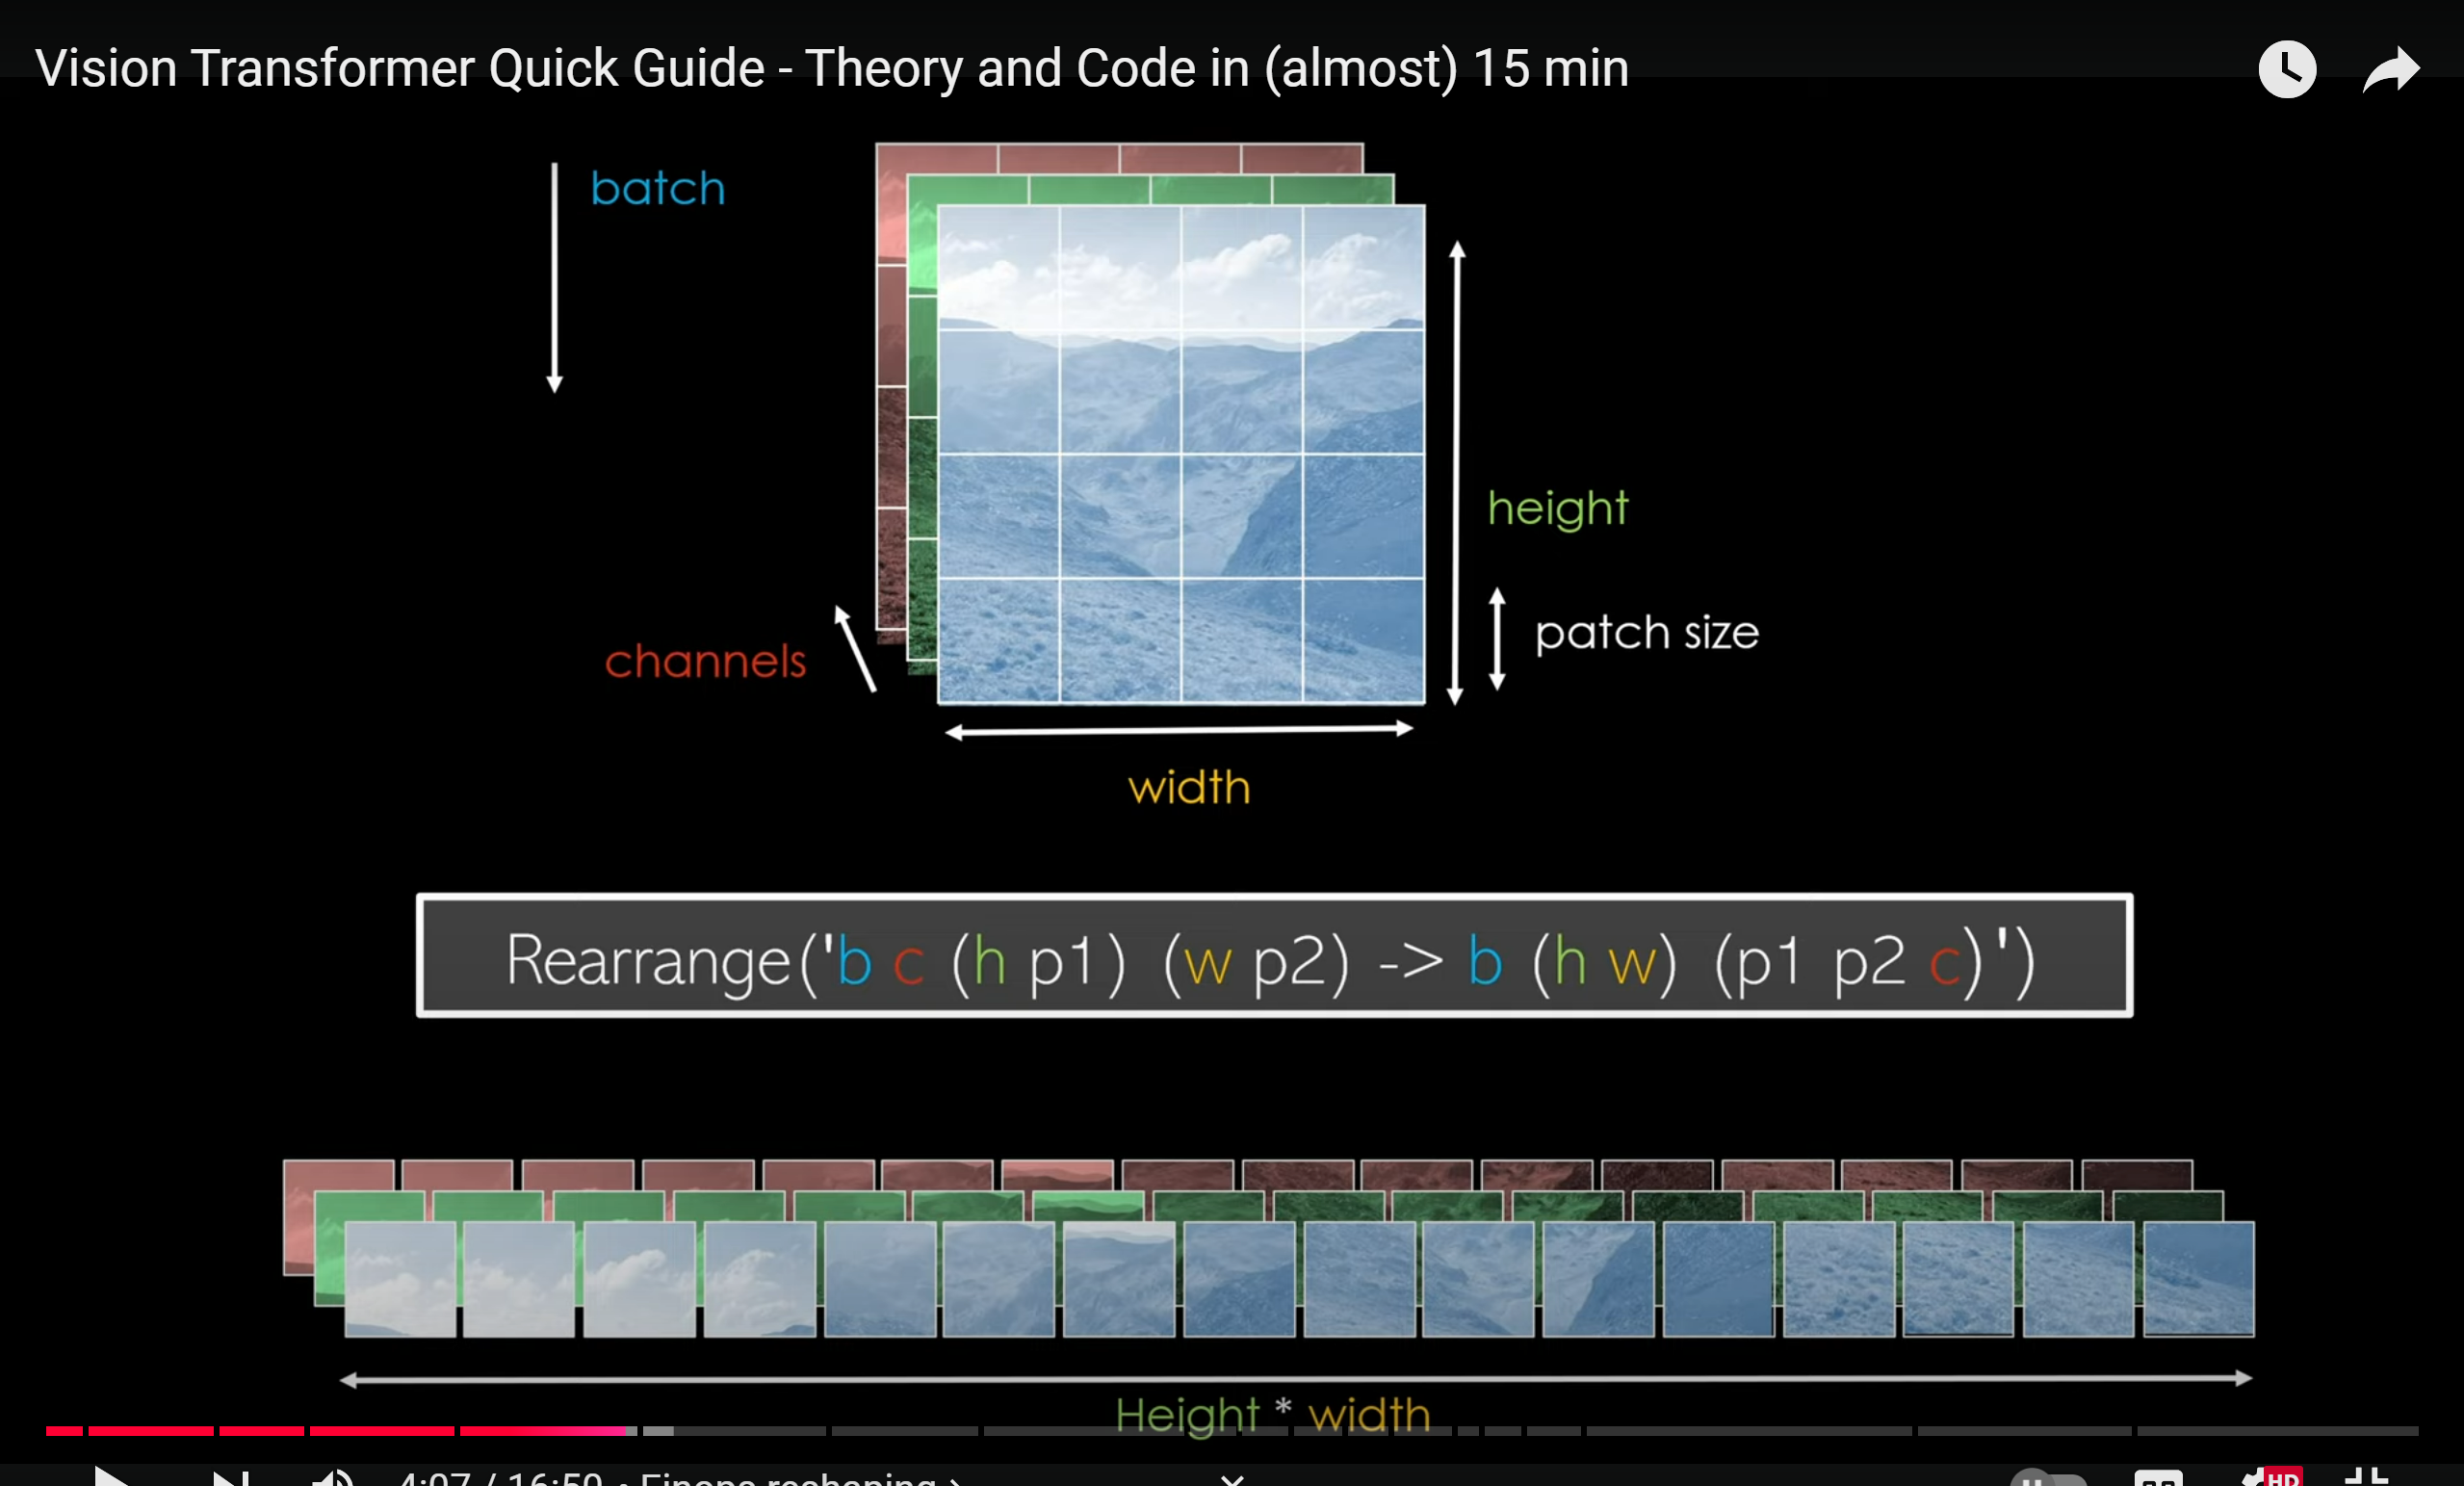

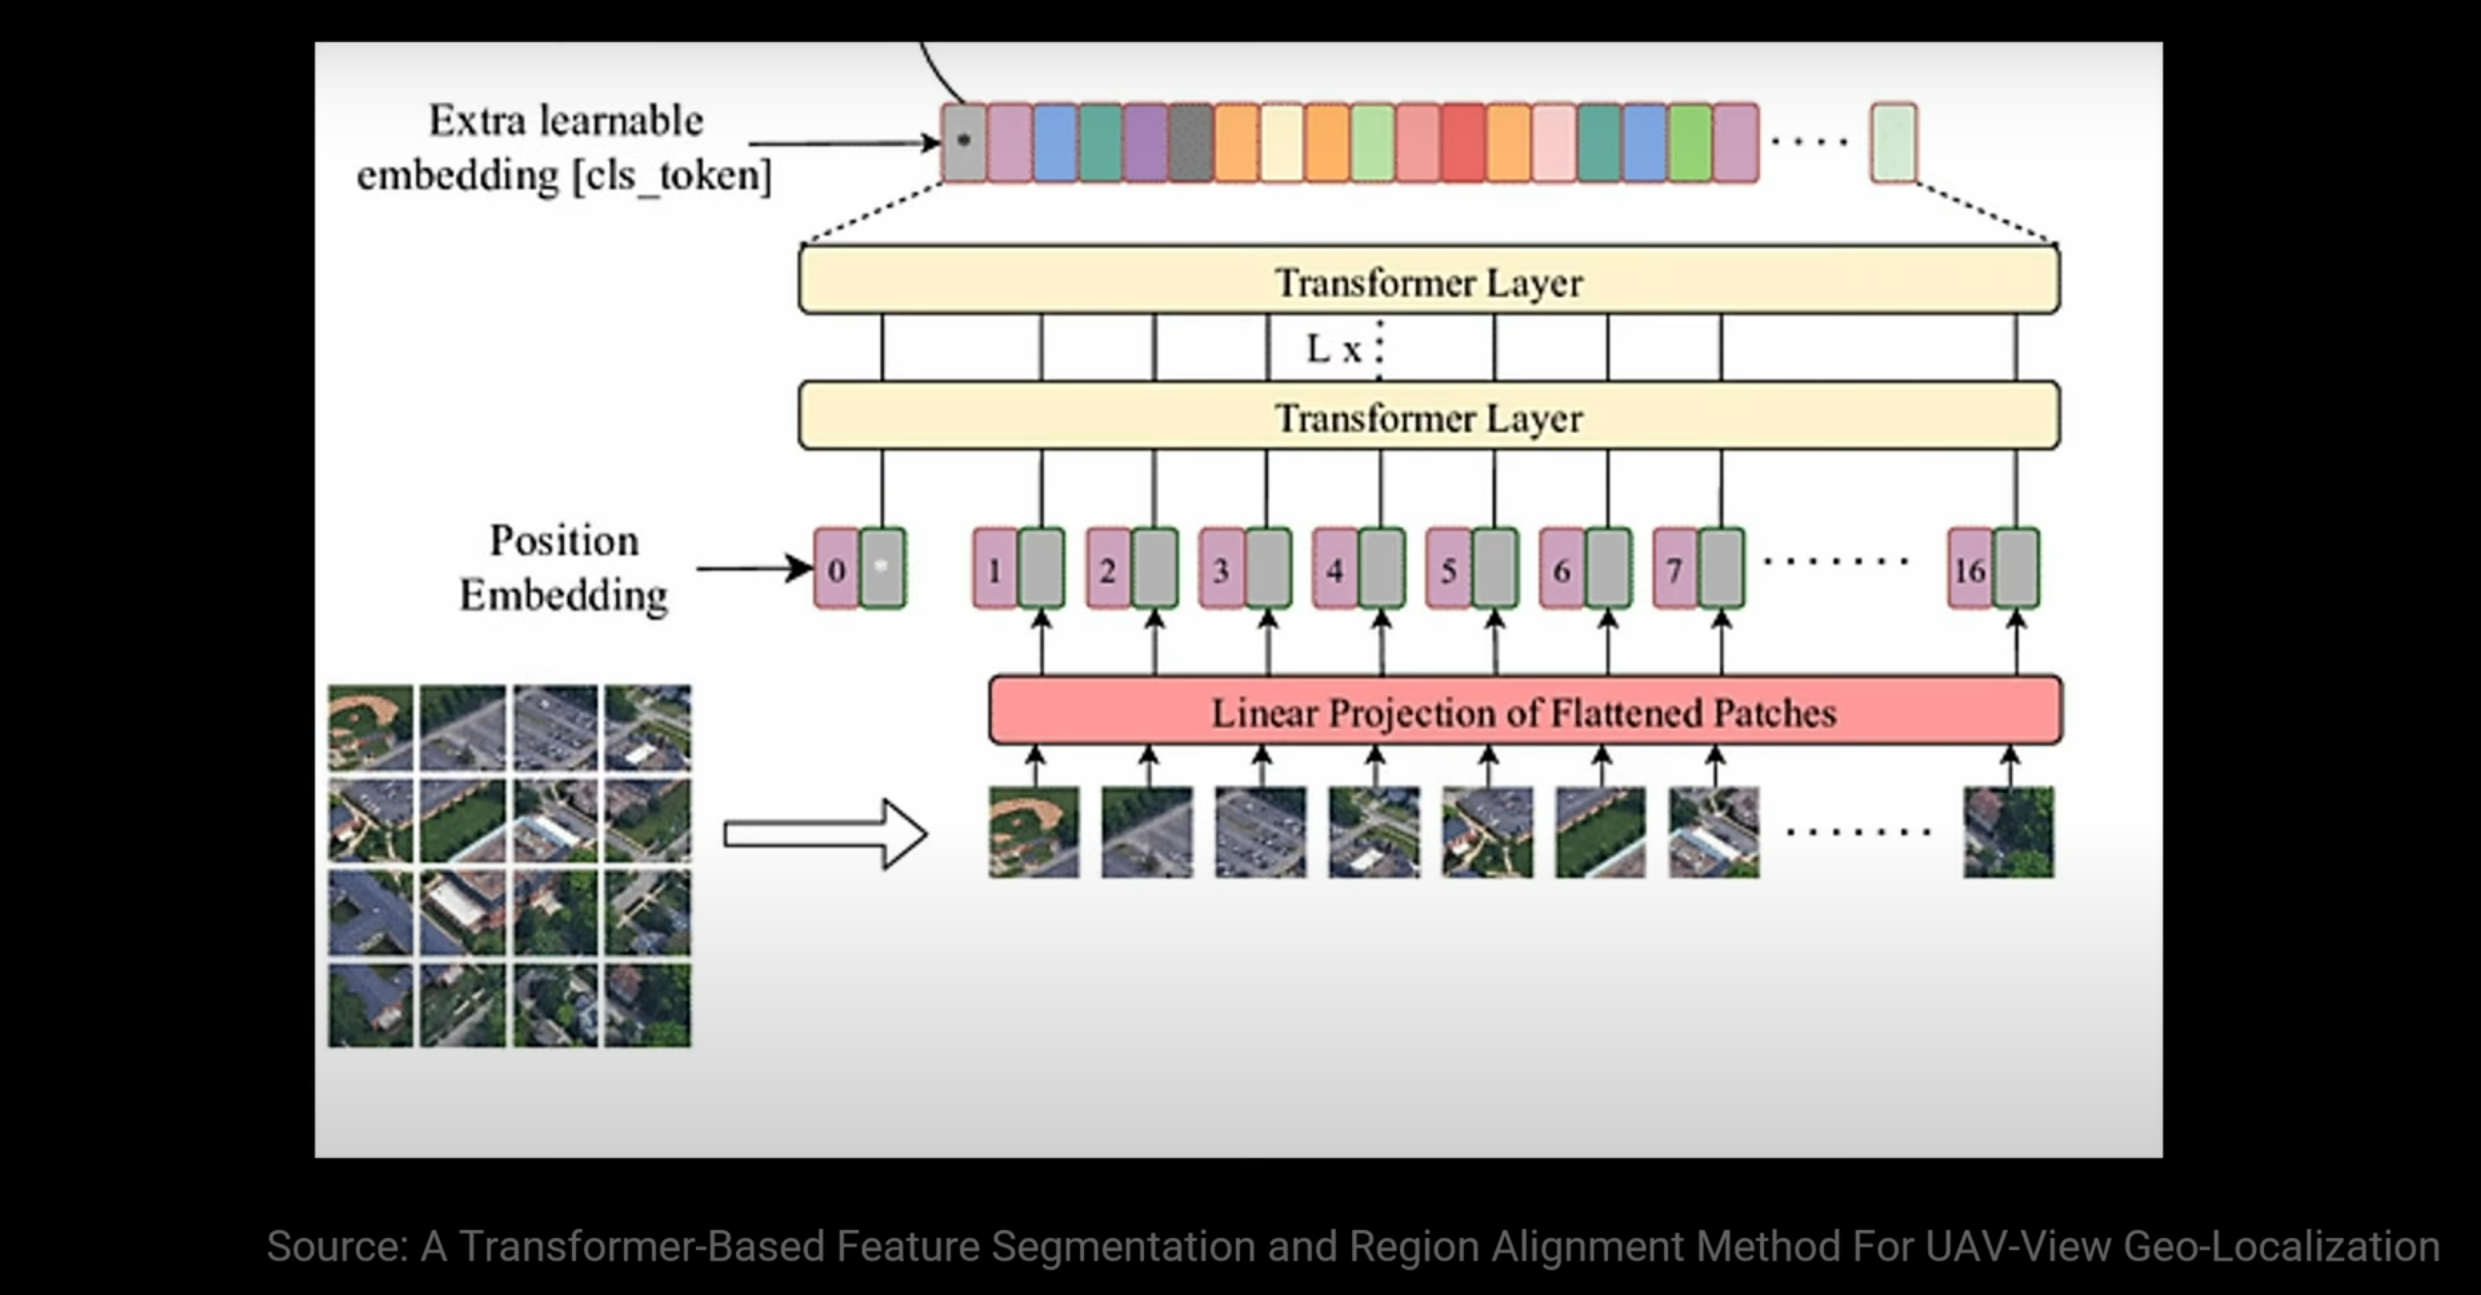

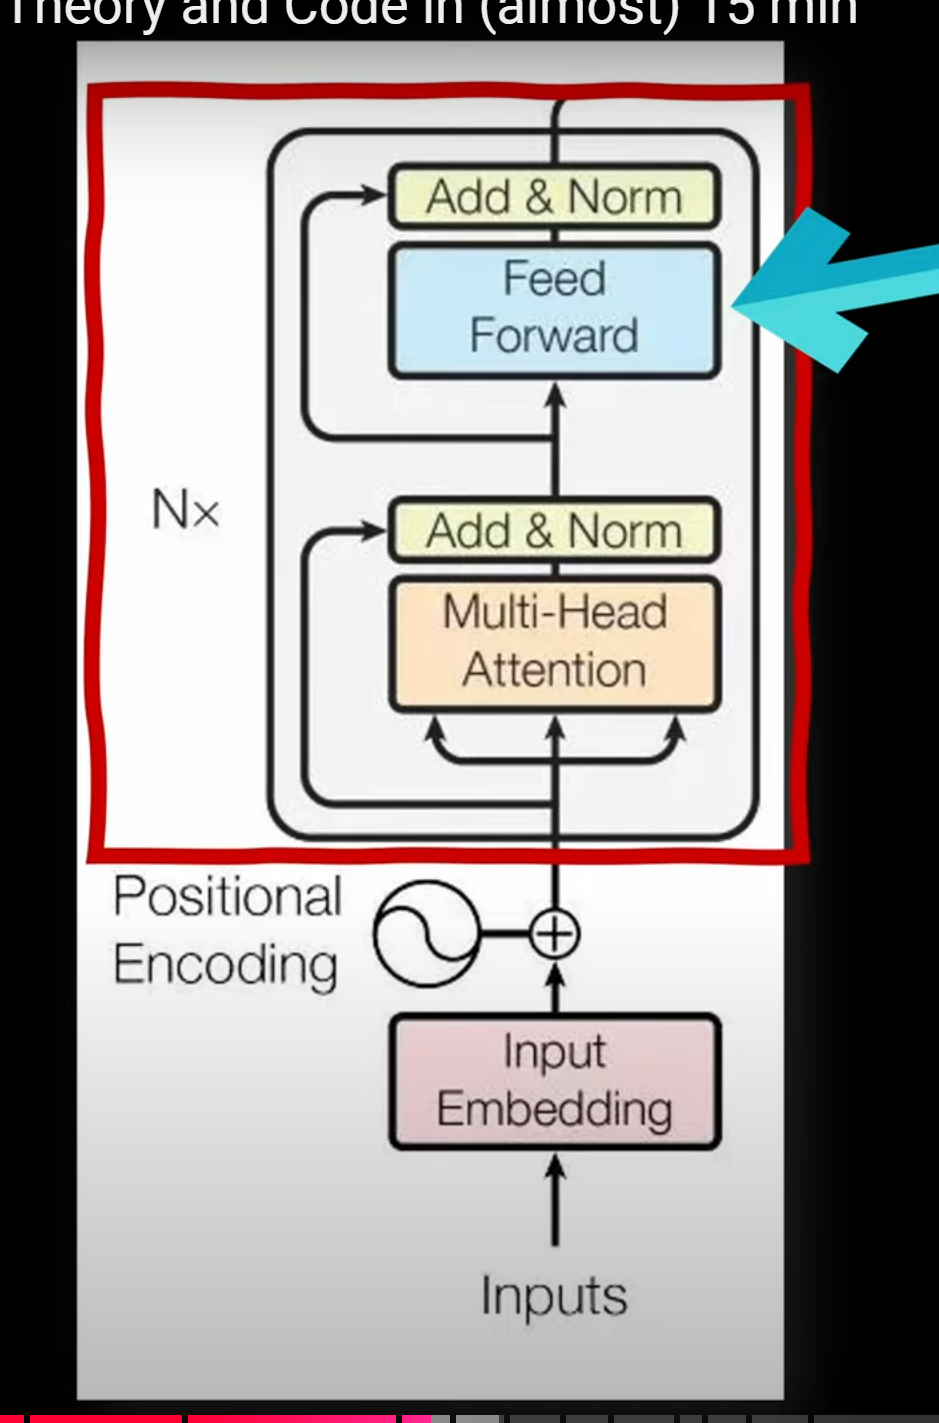



# Transformer Block

In [1]:
from torch import nn



class TransformerEncoder(nn.Module):
    """Custom Transformer Block 

    Assume embed_dim is the same all along, the shape of input X, or the last dimension of X
    That means transformer encoder does not change dim of the input
    It accepts shape (B, L, E), where B is batch size, L is sequence length, E is feature dimension
    """
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim  # E
        self.multihead_attn = nn.MultiheadAttention(embed_dim = self.embed_dim, num_heads=2, batch_first=True)
        self.WQ = nn.Linear(self.embed_dim, self.embed_dim)
        self.WK = nn.Linear(self.embed_dim, self.embed_dim)
        self.WV = nn.Linear(self.embed_dim, self.embed_dim)
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.embed_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim * 2),
            nn.GELU(),
            nn.Linear(self.embed_dim * 2, self.embed_dim),
        )
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.embed_dim)
        
    def forward(self, X):
        residual = X
        q = self.WQ(X)
        k = self.WK(X)
        v = self.WV(X)
        attn_output, attn_output_weights = self.multihead_attn(q, k, v)  # (B, L, E)
        X = attn_output + residual
        X = self.layer_norm_1(X)
        
        residual = X
        X = self.feed_forward(X)
        X = X + residual
        X = self.layer_norm_2(X)
        
        return X
        

In [2]:
from torchinfo import summary

model = TransformerEncoder(embed_dim=256)
summary(model, (4, 65, 256))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerEncoder                       [4, 65, 256]              --
├─Linear: 1-1                            [4, 65, 256]              65,792
├─Linear: 1-2                            [4, 65, 256]              65,792
├─Linear: 1-3                            [4, 65, 256]              65,792
├─MultiheadAttention: 1-4                [4, 65, 256]              263,168
├─LayerNorm: 1-5                         [4, 65, 256]              512
├─Sequential: 1-6                        [4, 65, 256]              --
│    └─Linear: 2-1                       [4, 65, 512]              131,584
│    └─GELU: 2-2                         [4, 65, 512]              --
│    └─Linear: 2-3                       [4, 65, 256]              131,328
├─LayerNorm: 1-7                         [4, 65, 256]              512
Total params: 724,480
Trainable params: 724,480
Non-trainable params: 0
Total mult-adds (M): 1.85
Input size (MB): 0.27
Forwar

# Patching

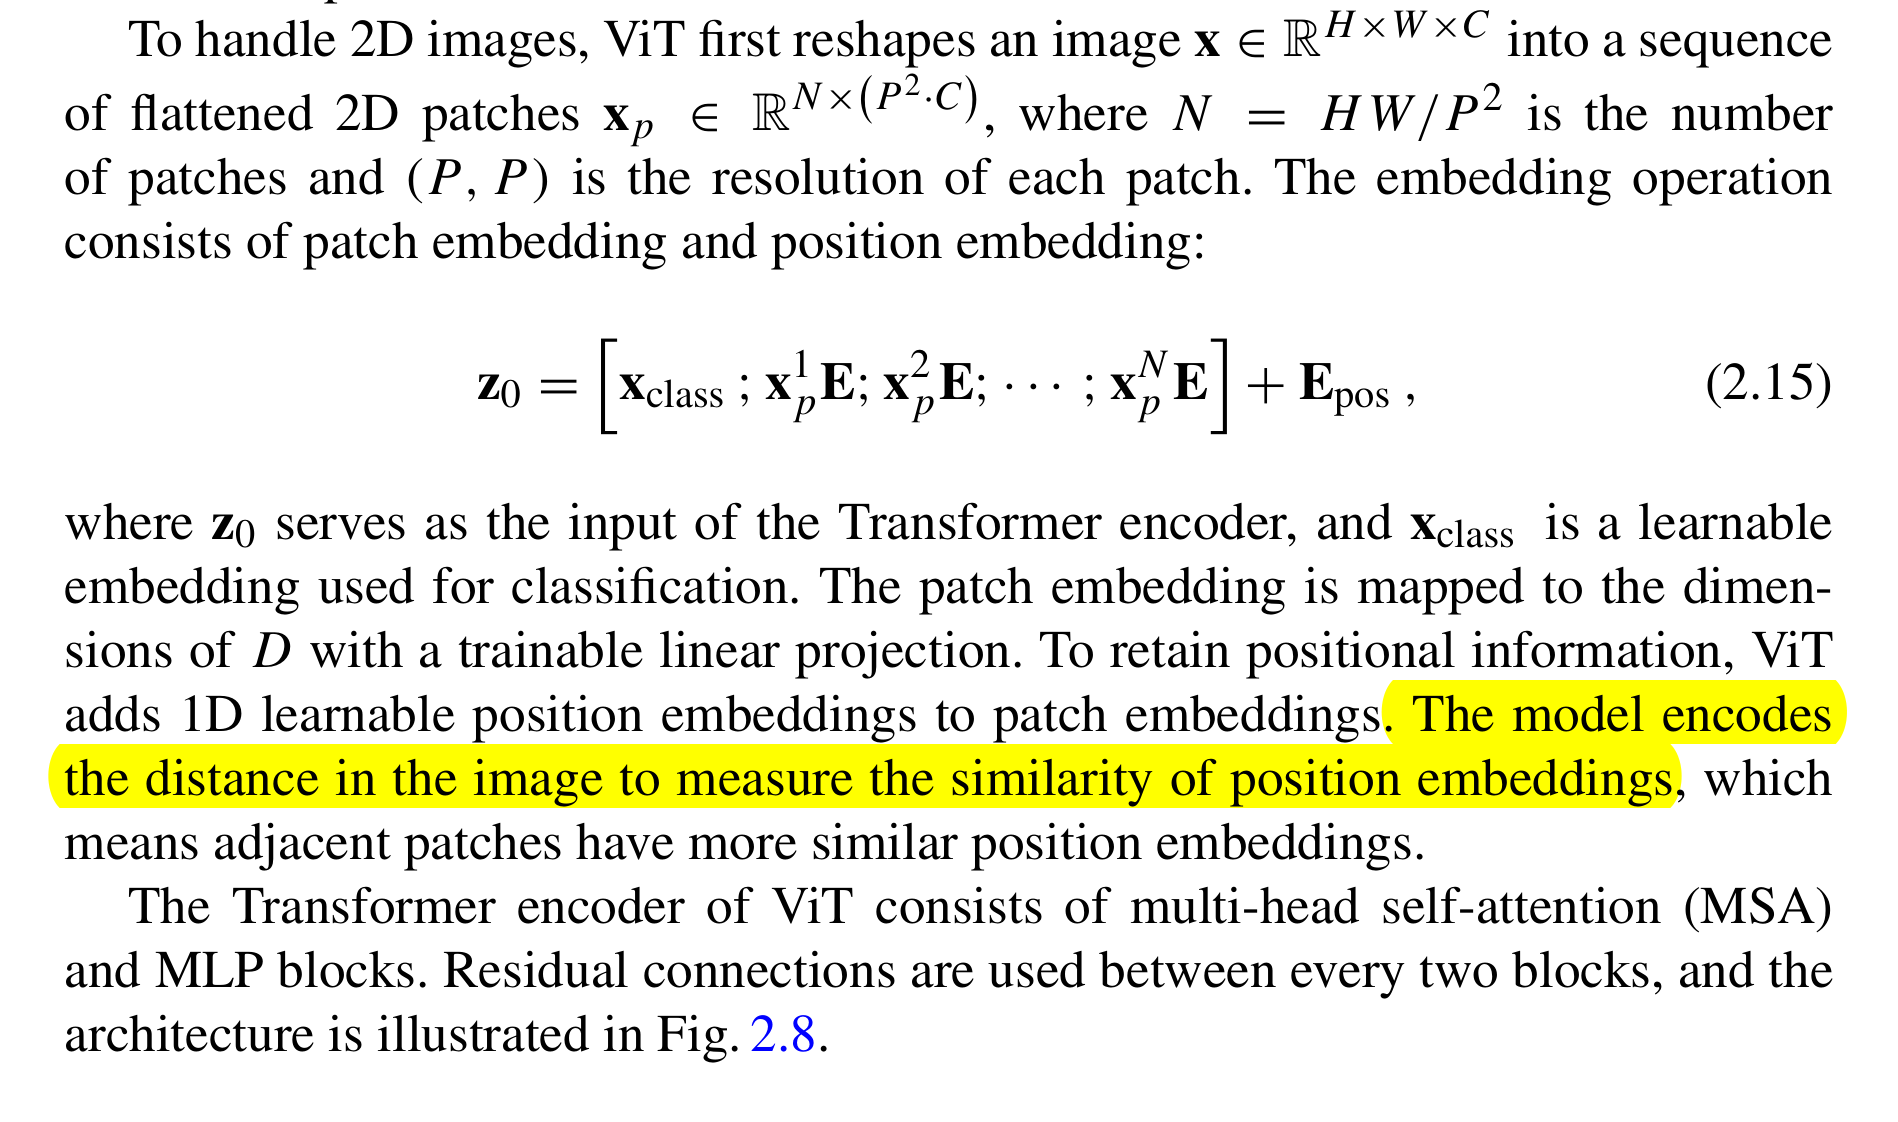

In [3]:
from einops import rearrange, repeat
import torch

class PatchEmbedding(nn.Module):
    """Assume patch is square"""
    def __init__(self, patch_size, embed_dim, in_channel, img_h, img_w):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Linear(patch_size * patch_size * in_channel, embed_dim)
        self.cls_token = nn.Parameter(torch.randn((1, embed_dim)))
        num_patches = img_h * img_w // (patch_size ** 2)
        self.pos_encoding = nn.Parameter(torch.randn((num_patches + 2, embed_dim)))
    
    def forward(self, X):
        """X.shape = [B, C, H, W]
        Linear projection of flatten patches
        Linear module only applies the last dimension. It is useful to think of any previous dimension as batch size
        Return shape = [B, L, embed_dim]
        """
        X = rearrange(X, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = self.patch_size, p2 = self.patch_size)
        X = self.projection(X)
        
        # Handle class token
        clss_token = repeat(self.cls_token, '1 E -> B 1 E', B = X.shape[0])
        # All tensors must have the same shape, except along the dimension you want to concatenate.
        X = torch.cat([clss_token, X], dim=1)
        
        # Handle positional encoding, train a full size encoding and slice from it
        B, L, E = X.shape
        pos_encoding = self.pos_encoding[:L]
        pos_encoding = pos_encoding.unsqueeze(0)
        
        X = X + pos_encoding
        return X

model = PatchEmbedding(patch_size=16, embed_dim=600, in_channel=3, img_h=240, img_w=160)
summary(model, (56, 3, 240, 160))

Layer (type:depth-idx)                   Output Shape              Param #
PatchEmbedding                           [56, 151, 600]            91,800
├─Linear: 1-1                            [56, 150, 600]            461,400
Total params: 553,200
Trainable params: 553,200
Non-trainable params: 0
Total mult-adds (M): 25.84
Input size (MB): 25.80
Forward/backward pass size (MB): 40.32
Params size (MB): 1.85
Estimated Total Size (MB): 67.97